In [1]:
# Load Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk as nlp
import re
import string

nlp.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize

nlp.download('wordnet')
from nltk.stem import WordNetLemmatizer 

nlp.download('punkt')

from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble

from sklearn.model_selection import train_test_split

# Metrics
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import average_precision_score, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

from sklearn.utils import resample

from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Peter\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Peter\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Peter\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# Load Data
real = pd.read_csv('True.csv')
fake = pd.read_csv('Fake.csv')

In [3]:
# Combine Datasets
fake['Class'] = 1
real['Class'] = 0

cols = ['text', 'Class']

news = pd.concat([fake[cols], real[cols]]).reset_index(drop = True)
news.head()

,text,Class
0,Donald Trump just couldn t wish all Americans ...,1
1,House Intelligence Committee Chairman Devin Nu...,1
2,"On Friday, it was revealed that former Milwauk...",1
3,"On Christmas day, Donald Trump announced that ...",1
4,Pope Francis used his annual Christmas Day mes...,1


In [4]:
# Check for null values
news.isnull().sum()

text     0
Class    0
dtype: int64

In [5]:
# Check for duplicates
duplicates = news[news.duplicated()]
print(duplicates)

# Drop duplicates
news = news.drop_duplicates()

                                                    text  Class
9114   AP News  The regulars amble in before dawn and...      1
9738   Things didn t go as well as Nicholle had hoped...      1
9942   No time to waste   we've got to fight with eve...      1
11041                                                         1
11190                                                         1
...                                                  ...    ...
44709  PARIS (Reuters) - French President Emmanuel Ma...      0
44744  GUATEMALA CITY (Reuters) - Guatemala s top cou...      0
44771  PARIS (Reuters) - Europe s  big four  continen...      0
44834  BANGKOK (Reuters) - Ousted Thai prime minister...      0
44889  GENEVA (Reuters) - North Korea and the United ...      0

[6251 rows x 2 columns]


In [6]:
# Check size of each class
news.Class.value_counts()

0    21192
1    17455
Name: Class, dtype: int64

In [7]:
for index,text in enumerate(news['text'][5:7]):
  print('\nArticle %d:\n'%(index+1),text)


Article 1:
 The number of cases of cops brutalizing and killing people of color seems to see no end. Now, we have another case that needs to be shared far and wide. An Alabama woman by the name of Angela Williams shared a graphic photo of her son, lying in a hospital bed with a beaten and fractured face, on Facebook. It needs to be shared far and wide, because this is unacceptable.It is unclear why Williams  son was in police custody or what sort of altercation resulted in his arrest, but when you see the photo you will realize that these details matter not. Cops are not supposed to beat and brutalize those in their custody. In the post you are about to see, Ms. Williams expresses her hope that the cops had their body cameras on while they were beating her son, but I think we all know that there will be some kind of convenient  malfunction  to explain away the lack of existence of dash or body camera footage of what was clearly a brutal beating. Hell, it could even be described as att

In [8]:
def prepare_text(text_list):
    stop_words = set(stopwords.words('english')) 
    custom_stop_words = ['reuters', 'washington', 'new', 'york', 'london']
    
    lemmatizer = WordNetLemmatizer() 
    
    # Convert text to lower case
    out = text_list.apply(lambda x: x.lower())
    
    # Remove numbers and words containing numbers
    out = out.apply(lambda x: re.sub('\w*\d\w*','', x))
    
    # Remove punctiation
    out = out.apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))

    # Tokenize words
    tokens = out.apply(lambda x: word_tokenize(x))
    
    # Remove stopwords
    tokens = tokens.apply(lambda x: ([item for item in x if item not in stop_words]))
    
    # Remove custom stopwords
    tokens = tokens.apply(lambda x: ([item for item in x if item not in custom_stop_words]))
    
    # Word lemmitization
    tokens = tokens.apply(lambda x: ([lemmatizer.lemmatize(item) for item in x]))
    
    # Convert tokens back into string
    out = tokens.apply(lambda x: ' '.join(x))
    
    return out

In [9]:
news['text_processed'] = prepare_text(news['text'])

In [10]:
for index,text in enumerate(news['text_processed'][5:7]):
  print('\nArticle %d:\n'%(index+1),text)


Article 1:
 number case cop brutalizing killing people color seems see end another case need shared far wide alabama woman name angela williams shared graphic photo son lying hospital bed beaten fractured face facebook need shared far wide unacceptableit unclear williams son police custody sort altercation resulted arrest see photo realize detail matter cop supposed beat brutalize custody post see m williams express hope cop body camera beating son think know kind convenient malfunction explain away lack existence dash body camera footage clearly brutal beating hell could even described attempted murder something tell young man never without ado troy alabama finest decided appropriate treatment angela williams sonno matter perceived crime young man might completely unacceptable cop need rot jail long long time wan na bet get paid vacation force investigates officer returned duty posthastethis folk say black life matter way hell would happened angela williams son white please share far

In [11]:
# Check size of each class
news.Class.value_counts()

0    21192
1    17455
Name: Class, dtype: int64

In [12]:
# Undersample real news to match fake news

real_news = news[news.Class == 0]
fake_news = news[news.Class == 1]

fake_news_size = len(fake_news)

real_news = resample(real_news, replace=False, n_samples=fake_news_size, random_state=15)

news = pd.concat([real_news, fake_news])

# Check size of each class
news.Class.value_counts()

1    17455
0    17455
Name: Class, dtype: int64

In [13]:
# Split into test and training data
X  = news['text_processed']
y = news['Class']

In [14]:
def EvaluateModel(pipeline):
  predictions =  cross_val_predict(pipeline, X, y, cv=5)

  report = classification_report(y, predictions)
  cf_matrix = confusion_matrix(y, predictions)
  ap_score = average_precision_score(y, predictions)
  
  print("Model Performance Metrics\n")
  print(report)
  print('Average precision-recall score: {0:0.3f}'.format(ap_score))
  print("\nConfusion Matrix:")
  sns.heatmap(cf_matrix /np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')

In [15]:
# Multinominial Naive Bayes Classifier Pipeline
mnb = Pipeline(
    steps=[
           ('preprocessor', TfidfVectorizer(max_features=250, ngram_range=(1,2))),
           ('classifier', MultinomialNB())
    ]
)

# Logitstic Regression Classifier Pipeline
lr = Pipeline(
    steps=[
           ('preprocessor', TfidfVectorizer(max_features=250)),
           ('classifier', LogisticRegression())
    ]
)

Model Performance Metrics

              precision    recall  f1-score   support

           0       0.93      0.96      0.95     17455
           1       0.96      0.93      0.94     17455

    accuracy                           0.95     34910
   macro avg       0.95      0.95      0.95     34910
weighted avg       0.95      0.95      0.95     34910

Average precision-recall score: 0.928

Confusion Matrix:


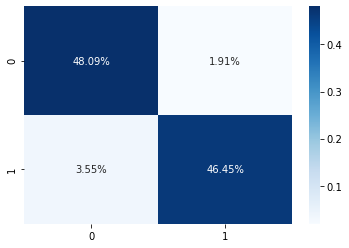

In [16]:
EvaluateModel(lr)

Model Performance Metrics

              precision    recall  f1-score   support

           0       0.88      0.91      0.89     17455
           1       0.91      0.87      0.89     17455

    accuracy                           0.89     34910
   macro avg       0.89      0.89      0.89     34910
weighted avg       0.89      0.89      0.89     34910

Average precision-recall score: 0.857

Confusion Matrix:


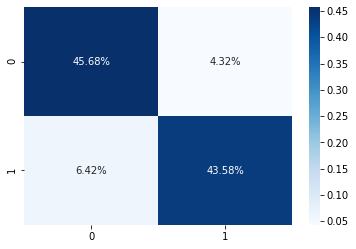

In [17]:
EvaluateModel(mnb)

# N-Gram Language Model

In [18]:
from nltk.lm.preprocessing import padded_everygram_pipeline
from nltk.lm import Laplace
from nltk.lm import WittenBellInterpolated, KneserNeyInterpolated
from nltk.tokenize.treebank import TreebankWordDetokenizer, TreebankWordTokenizer

nlp.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Peter\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [19]:
# Create list of sentences
stories = news[news.Class == 0]['text']
stories.head()

37546    MOSCOW (Reuters) - Russia s defense ministry h...
42387    KIEV (Reuters) - Massive explosions and a blaz...
37538    TEGUCIGALPA (Reuters) - Eight years after a co...
28817    HAVANA (Reuters) - The Mississippi ports of Pa...
37416    YANGON (Reuters) - Chinese President Xi Jinpin...
Name: text, dtype: object

In [20]:
tokenizer = TreebankWordTokenizer()

def clean_stories(text_list):
    # Convert text to lower case
    out = text_list.apply(lambda x: x.lower())
    # Remove numbers and words containing numbers
    out = out.apply(lambda x: re.sub('\w*\d\w*', '', x))

    # Remove and replace various quote characters
    out = out.apply(lambda x: re.sub(r'\“|\”', '', x))
    out = out.apply(lambda x: re.sub(r'\’', "", x))
    out = out.apply(lambda x: re.sub(r'\`', "", x))
    return out

def tokenize(text_list):
    sents = []
    for text in text_list:
        sent_tokens = sent_tokenize(text)
        for sent in sent_tokens:
            #sent = re.sub('[%s]' % re.escape(string.punctuation), '', sent)
            sents.append(tokenizer.tokenize(sent))
    return sents

In [26]:
text = clean_stories(stories[:1000])
sents = tokenize(text)

In [27]:
n_gram = 3

train_data, padded_sents = padded_everygram_pipeline(n_gram, sents)

model = KneserNeyInterpolated(n_gram)
model.fit(train_data, padded_sents)

In [28]:
detokenizer = TreebankWordDetokenizer()

def generate_sent(model, num_words, text_seed=''):
    seed = word_tokenize(text_seed)
    content = seed
    # content.append(seed)
    for token in model.generate(num_words, text_seed=seed):
        if token == '<s>':
            continue
        if token == '</s>':
            break
        content.append(token)
    return detokenizer.detokenize(content)

In [29]:
def write_story(model, length, feed_text=''):
    stop_words = set(stopwords.words('english'))
    story = []
    for i in range(length):
        sent_length = np.random.randint(low=10, high=25)
        sent = generate_sent(model, num_words=sent_length, text_seed=feed_text)
        sent = sent.capitalize()
        story.append(sent)
        sent = re.sub('[%s]' % re.escape(string.punctuation), '', sent.lower())
        words = word_tokenize(sent)

        nouns = [word for (word, pos) in nlp.pos_tag(words)
                 if(pos[:2] == 'NN')]
        nouns = [item for item in nouns if item not in stop_words]
        nouns = [item for item in nouns if item != feed_text]

        nouns_length = len(nouns)
        if nouns_length > 0:
            feed_word_loc = np.random.randint(low=0, high=nouns_length)
            feed_text = nouns[feed_word_loc]
        else:
            feed_text = ''
    return ' '.join(story)

In [30]:
write_story(model, 10)

'Probing for a possible sale to britain after it was like a visitor in my judgment right now, should it choose to scrap Judgment. Orthodoxy will come out stronger, he has no intention of firing leandra english, to block Orthodoxy will come back right now, it is not expected to pass a spending bill coming before house on saturday any Spending on non-defense programs, facilities and both the city. City has had recent contact with the republican candidate karen handel Karen weaver. Seabreeze partners management. Management llc and a cuban team sweat jacket and sunglasses, and nancy pelosi and schumer said on thursday Nancy reagan, who is a big postcard, mnuchin said'